# Bearing Failure Anomaly Detection

Based on https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection

Used to test random things, it is a lot of boilerplate.

In [62]:
!pip install scikit-learn joblib seaborn pydot

Defaulting to user installation because normal site-packages is not writeable


In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm import *



from numpy.random import seed
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Add,Flatten, UpSampling1D,Conv1DTranspose,Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Lambda, Reshape, Concatenate, Conv1D, Masking
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

2025-01-12 15:37:10.968048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736692631.059864   31034 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736692631.085275   31034 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 15:37:11.230129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# set random seed
seed(10)
tf.random.set_seed(10)

# Data loading and pre-processing
An assumption is that mechanical degradation in the bearings occurs gradually over time; therefore, we use one datapoint every 10 minutes in the analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

In [3]:
folder_path = "./MyData/"

# Get a list of all text files in the folder
file_list = glob(os.path.join(folder_path, "*.txt"))

# Create empty lists to store data from each file
all_gyro_data = []
all_acceleration_data = []
all_linear_acceleration_data = []

# Iterate through each file in the folder
for file_path in file_list:
    # Read the file into a DataFrame
    df = pd.read_csv(file_path, header=None)

    # Rename columns for clarity
    df.columns = ['Category', 'Timestamp', 'X', 'Y', 'Z']

    # Convert 'Timestamp' to datetime and set as the index
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df.set_index('Timestamp', inplace=True)

    # Split data based on the 'Category' column and drop the 'Category' column
    gyro_data = df[df['Category'] == 0].drop(columns=['Category'])
    acceleration_data = df[df['Category'] == 1].drop(columns=['Category'])
    linear_acceleration_data = df[df['Category'] == 2].drop(columns=['Category'])

    # Append the data to the corresponding lists
    all_gyro_data.append(gyro_data)
    all_acceleration_data.append(acceleration_data)
    all_linear_acceleration_data.append(linear_acceleration_data)

In [ ]:
all_gyro_data[1]

In [4]:
# transform data file index to datetime and sort in chronological order
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

NameError: name 'merged_data' is not defined

# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [9]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


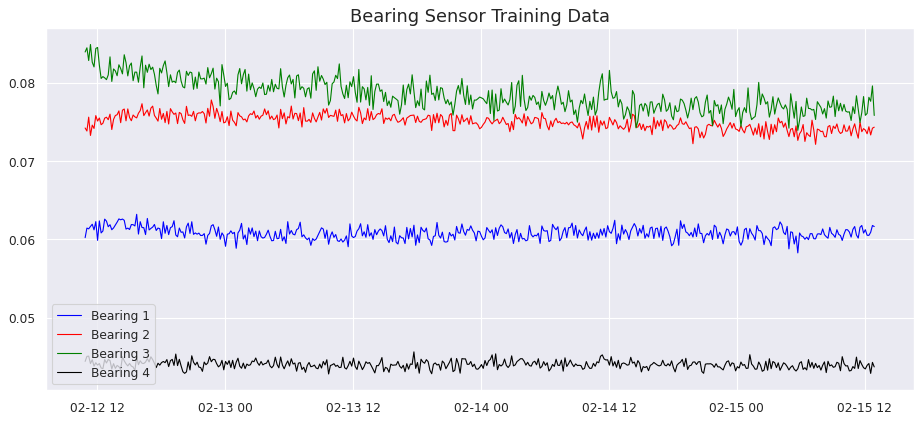

In [7]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [190]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
all_gyro_data_fft=[]
for train in all_gyro_data:
    all_gyro_data_fft.append(np.fft.fft(train))


IndexError: index 3 is out of bounds for axis 1 with size 3

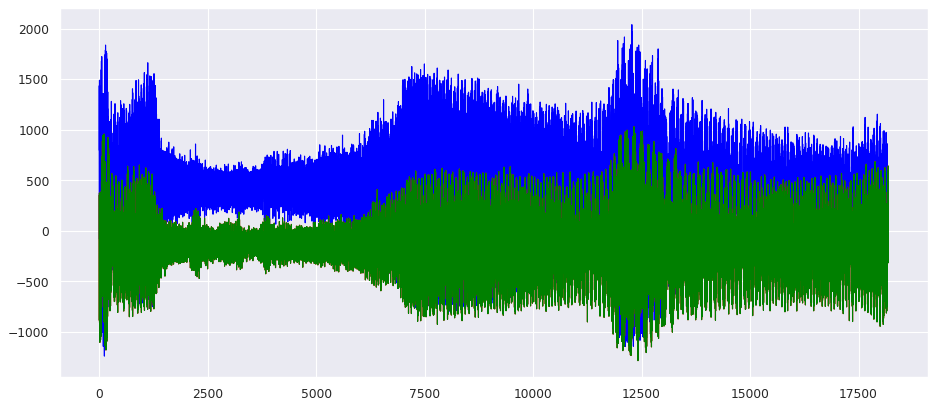

In [12]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(all_gyro_data_fft[0][:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(all_gyro_data_fft[0][:,1].real, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(all_gyro_data_fft[0][:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(all_gyro_data_fft[0][:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

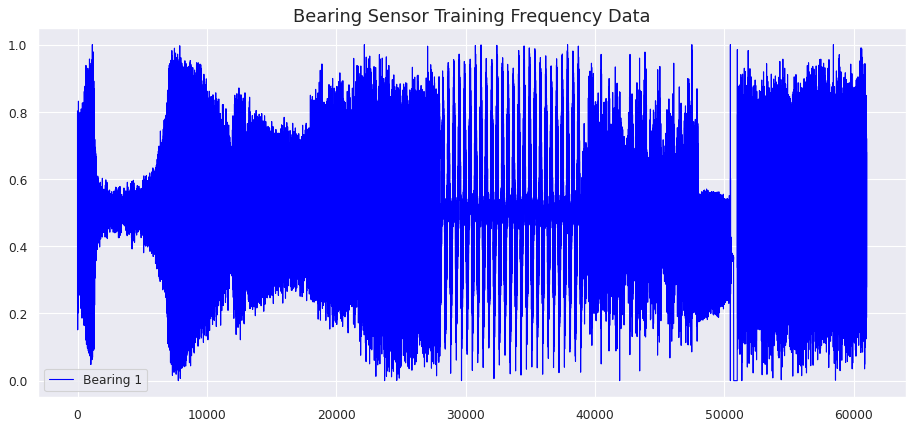

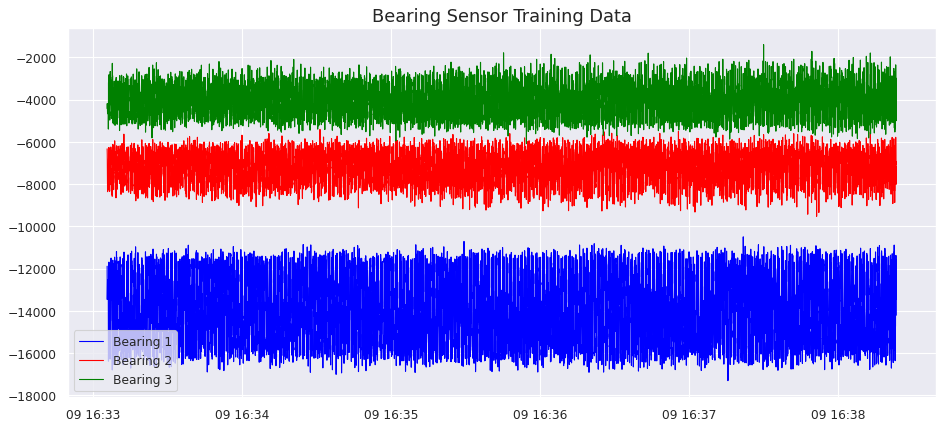

In [201]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(np.concatenate(X_train)[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
#ax.plot(all_gyro_data_fft[1][:,1].real, label='Bearing 2', color='red', animated = True, linewidth=1)
#ax.plot(all_gyro_data_fft[1][:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(all_acceleration_data [1]["X"], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(all_acceleration_data [1]["Y"], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(all_acceleration_data [1]["Z"], label='Bearing 3', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [5]:
X_train = []
for train in all_gyro_data:
    # Scale to [0, 1] using the known range
    min_val, max_val = -2**16, 2**16
    scaled_train = (train - min_val) / (max_val - min_val)  # Normalize to [0, 1]
    X_train.append(np.array(scaled_train))

    # Save the scaling parameters
    scaler_info = {"min_val": min_val, "max_val": max_val}
    joblib.dump(scaler_info, "scaler_data_manual.pkl")


In [190]:
X_train

[array([[0.50382233, 0.50233459, 0.49993134],
        [0.50059509, 0.50349426, 0.50687408],
        [0.49716949, 0.50442505, 0.5034256 ],
        ...,
        [0.50271606, 0.49427795, 0.50135803],
        [0.50023651, 0.50114441, 0.50092316],
        [0.49954987, 0.50304413, 0.50028229]]),
 array([[0.50025177, 0.50176239, 0.50170898],
        [0.50057983, 0.49839783, 0.49991608],
        [0.50363922, 0.49951935, 0.5018692 ],
        ...,
        [0.50118256, 0.49908447, 0.5007019 ],
        [0.50016785, 0.49510956, 0.50214386],
        [0.50289154, 0.50021362, 0.50132751]]),
 array([[0.45477295, 0.48532867, 0.48596191],
        [0.47612   , 0.4883194 , 0.49058533],
        [0.45908356, 0.48744202, 0.49014282],
        ...,
        [0.49838257, 0.50311279, 0.49104309],
        [0.54472351, 0.51329803, 0.51922607],
        [0.49573517, 0.49191284, 0.49409485]]),
 array([[0.50087738, 0.49873352, 0.50138855],
        [0.50045776, 0.49756622, 0.50240326],
        [0.50047302, 0.49945831, 0.

In [6]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train_reshaped=[]
for x in X_train:  
    x = x.reshape(x.shape[0],  x.shape[1])
    print("Training data shape:", x.shape)
    X_train_reshaped.append(x)


Training data shape: (18189, 3)
Training data shape: (10458, 3)
Training data shape: (11490, 3)
Training data shape: (9281, 3)
Training data shape: (2716, 3)
Training data shape: (10094, 3)


In [7]:
# normalize the data
X_train_number=[]
X_train_processed = []
for j,seq in enumerate(X_train_reshaped):
        segments = []
        for i in range(0, len(seq), 1000):
            chunk = seq[i:i+1000]
            if len(chunk) > 700:  # Pad the last chunk if necessary
                chunk = pad_sequences([chunk], maxlen=1000, padding='post', dtype='float32')[0]
                segments.append(chunk)
                X_train_number.append(j)
        X_train_processed.extend(segments)
X_train=np.array(X_train_processed)

In [8]:
couples=[]
Y_train=[]
for i in range(len(X_train_processed)):
    for j in range(len(X_train_processed)):
        couples.append([X_train_processed[i],X_train_processed[j]])
        if i==j:
            Y_train.append(0)
        else:
            Y_train.append(1)

In [ ]:
Y_train

In [70]:
def autoencoder_model(X):
    inputs = Input(shape=( None,X.shape[2]))
    print(inputs)
    reference_inputs = Input(shape=(None, X.shape[2]))
    print(reference_inputs)

    # Encoder for main input
    L1 = LSTM(16, activation='relu', return_sequences=True)(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)

    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    reconstruction_output = TimeDistributed(Dense(X.shape[2]))(L5)

    # Encoder for reference input
    R1 = LSTM(16, activation='relu', return_sequences=False)(reference_inputs)
    R2 = RepeatVector(X.shape[1])(R1)

    # Combine outputs
    combined = Concatenate()([reconstruction_output, R2])
    anomaly_score = Dense(1, activation='sigmoid', name='anomaly_score')(combined)

    # Final model with both reconstruction and anomaly outputs
    model = Model(inputs=[inputs, reference_inputs], outputs=[reconstruction_output, anomaly_score])
    return model

In [35]:
def autoencoder_model_test(X):
    inputs = Input(shape=( None,X.shape[2]))


    # Encoder for main input
    L1 = LSTM(16, activation='relu', return_sequences=True)(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    model = Model(inputs=[inputs], outputs=[L2])
    return model
model=autoencoder_model_test(np.array([X_train[0].squeeze()]))

In [31]:
X_train[0].squeeze()
print(np.array([X_train[0].squeeze()]).shape)

(1, 18189, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.         0.11924321 0.03114934 0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.         0.11547667 0.05106353 0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.         0.10442453 0.01019037 0.        ]]


In [65]:
def autoencoder_model_test():
    encoder_inputs = Input(shape=(None, input_dim))  # Variable-length sequences
    masked=Masking(mask_value=0.0, input_shape=(None, 3))(encoder_inputs)
    
    encoder_lstm1 = LSTM(32, return_sequences=True)(masked)
    encoder_lstm2 = LSTM(latent_dim, return_state=True)
    _, state_h, state_c = encoder_lstm2(encoder_lstm1)
    
    # Decoder
    decoder_inputs = RepeatVector(tf.shape(encoder_inputs)[1])(state_h)  # Repeat latent state
    decoder_lstm1 = LSTM(latent_dim, return_sequences=True)(decoder_inputs, initial_state=[state_h, state_c])
    decoder_lstm2 = LSTM(32, return_sequences=True)
    decoder_outputs = decoder_lstm2(decoder_lstm1)
    decoded = TimeDistributed(Dense(input_dim))(decoder_outputs)
    model=Model(encoder_inputs, decoded)


    return model

# Example usage
X_train = np.random.rand(10, 18189, 3)  # Example dataset with batch size 10
model = autoencoder_model_test(X_train)
model.compile(optimizer='adam', loss='mse')

# Prediction
output = model.predict(X_train)  # Entire sequence is processed at once
print(output)  

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [42]:
def autoencoder_model_large():
    # Use None for variable sequence length
    inputs = Input(shape=(None, 3), name='Input_Layer')  # Variable-length sequences with 3 features
    
    # Masking Layer: Ignore padded time steps (e.g., where features are all zeros)
    #masked_inputs = Masking(mask_value=0.0, name='Masking_Layer')(inputs)
    
    # Encoder
    encoder_lstm_1 = LSTM(64, activation='relu', return_sequences=True, 
                          kernel_regularizer=regularizers.l2(0.00), name='Encoder_LSTM_1')(inputs)
    encoder_lstm_2 = LSTM(32, activation='relu', return_sequences=True, name='encoder')(encoder_lstm_1)
    
    # Decoder
    decoder_lstm_1 = LSTM(32, activation='relu', return_sequences=True, name='Decoder_LSTM_1')(encoder_lstm_2)
    decoder_lstm_2 = LSTM(64, activation='relu', return_sequences=True, name='decoder')(decoder_lstm_1)
    
    # Output
    output = TimeDistributed(Dense(3), name='Output_Layer')(decoder_lstm_2)  # Output matches input features
    
    # Model
    model = Model(inputs=inputs, outputs=output, name='LSTM_Autoencoder')
    return model

In [43]:
autoencoder_large=autoencoder_model_large()
autoencoder_large.compile(optimizer='adam', loss='mse')
autoencoder_large.summary()


Model: "LSTM_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, None, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_LSTM_1 (LSTM)           │ (None, None, 64)       │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (LSTM)                  │ (None, None, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_LSTM_1 (LSTM)           │ (None, None, 32)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (LSTM)                  │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (TimeDistributed)  │ (None, None, 3)        │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,171 (246.76 KB)

 Trainable params: 63,171 (246.76 KB)

 Non-trainable params: 0 (0.00 B)

In [190]:
import tensorflow.keras.backend as K
print(X_train[0].shape)
print(K.reshape(X_train[0], (-1, 1, 3)).shape)
X_train[0].shape


(18189, 1, 3)
(18189, 1, 3)


(18189, 1, 3)

In [ ]:
model_path = "./model.keras"

model = load_model(model_path)

model.summary()

In [121]:
model_path = "./model_fpn.keras"

model_fpn.save(model_path)



In [9]:
def autoencoder_model_standard():
    # Input layer with variable sequence length, padded to 1000 steps
    inputs = Input(shape=(1000, 3), name='Input_Layer')  # Padded sequences with 3 features

    # Masking Layer: Ignore padded time steps (e.g., where features are all zeros)
    masked_inputs = Masking(mask_value=0.0, name='Masking_Layer')(inputs)

    # Encoder
    encoder_lstm_1 = LSTM(16, activation='relu', return_sequences=True,
                          kernel_regularizer=regularizers.l2(0.00), name='Encoder_LSTM_1')(masked_inputs)
    encoder_lstm_2 = LSTM(8, activation='relu', return_sequences=True, name='Encoder_LSTM_2')(encoder_lstm_1)

    # Decoder
    decoder_lstm_1 = LSTM(8, activation='relu', return_sequences=True, name='Decoder_LSTM_1')(encoder_lstm_2)
    decoder_lstm_2 = LSTM(16, activation='relu', return_sequences=True, name='Decoder_LSTM_2')(decoder_lstm_1)

    # Output layer: Reconstruct the original input features
    outputs = Dense(3, name='Output_Layer')(decoder_lstm_2)

    # Build the model
    model = Model(inputs=inputs, outputs=outputs, name='LSTM_Autoencoder')
    #model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Masking
from tensorflow.keras import regularizers

def autoencoder_model_variable():
    # Use None for variable sequence length
    inputs = Input(shape=(None, 1), name='Input_Layer')  # Variable-length sequences with 3 features
    
    # Masking Layer: Ignore padded time steps (e.g., where features are all zeros)
    #masked_inputs = Masking(mask_value=0.0, name='Masking_Layer')(inputs)
    
    # Encoder
    encoder_lstm_1 = LSTM(16, activation='relu', return_sequences=True, 
                          kernel_regularizer=regularizers.l2(0.00), name='Encoder_LSTM_1')(inputs)
    encoder_lstm_2 = LSTM(8, activation='relu', return_sequences=True, name='encoder')(encoder_lstm_1)
    
    # Decoder
    decoder_lstm_1 = LSTM(8, activation='relu', return_sequences=True, name='Decoder_LSTM_1')(encoder_lstm_2)
    decoder_lstm_2 = LSTM(16, activation='relu', return_sequences=True, name='decoder')(decoder_lstm_1)
    
    # Output
    output = TimeDistributed(Dense(1), name='Output_Layer')(decoder_lstm_2)  # Output matches input features
    
    # Model
    model = Model(inputs=inputs, outputs=output, name='LSTM_Autoencoder')
    return model


In [10]:
tf.config.run_functions_eagerly(False)

# create the autoencoder model
autoencoder_model = autoencoder_model_standard()

autoencoder_model.compile(optimizer='adam', loss='mse')
autoencoder_model.summary()

2025-01-12 15:38:46.540343: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "LSTM_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 1000, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 1000, 3)   │          0 │ Input_Layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Masking_Layer       │ (None, 1000, 3)   │          0 │ Input_Layer[0][0] │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 1000)      │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_LSTM_1      │ (None, 1000, 16)  │      1,280 │ Masking_Layer[0]… │
│ (LSTM)              │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_LSTM_2      │ (None, 1000, 8)   │        800 │ Encoder_LSTM_1[0… │
│ (LSTM)              │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_LSTM_1      │ (None, 1000, 8)   │        544 │ Encoder_LSTM_2[0… │
│ (LSTM)              │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_LSTM_2      │ (None, 1000, 16)  │      1,600 │ Decoder_LSTM_1[0… │
│ (LSTM)              │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 1000, 3)   │         51 │ Decoder_LSTM_2[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,275 (16.70 KB)

 Trainable params: 4,275 (16.70 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
tf.config.run_functions_eagerly(False)

# create the autoencoder model
autoencoder_model = autoencoder_model_variable()

autoencoder_model.compile(optimizer='adam', loss='mse')
autoencoder_model.summary()

Model: "LSTM_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_LSTM_1 (LSTM)           │ (None, None, 16)       │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (LSTM)                  │ (None, None, 8)        │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_LSTM_1 (LSTM)           │ (None, None, 8)        │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (LSTM)                  │ (None, None, 16)       │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (TimeDistributed)  │ (None, None, 1)        │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,113 (16.07 KB)

 Trainable params: 4,113 (16.07 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
autoencoder_model.fit(np.array([np.array(X_train_processed)[0][:,0]]),np.array([np.array(X_train_processed)[0][:,0]]),epochs=15, batch_size=10)

Epoch 1/15


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [30]:
np.array(X_train_processed)[0][:,0]

array([0.5038223 , 0.5005951 , 0.4971695 , 0.50016785, 0.50320435,
       0.5009155 , 0.49729156, 0.49919128, 0.5032959 , 0.50064087,
       0.49720764, 0.49930573, 0.5020523 , 0.5005264 , 0.4962616 ,
       0.49900055, 0.50222015, 0.5001831 , 0.49689484, 0.49850464,
       0.50196075, 0.5000076 , 0.49694824, 0.49877167, 0.50188446,
       0.50032806, 0.49684143, 0.49851227, 0.501564  , 0.5006256 ,
       0.49713898, 0.49835205, 0.5013809 , 0.50076294, 0.49791718,
       0.49812317, 0.50237274, 0.50019073, 0.49741364, 0.4988098 ,
       0.50177765, 0.50161743, 0.49770355, 0.49868774, 0.5015793 ,
       0.50148773, 0.49928284, 0.49822998, 0.501091  , 0.50141144,
       0.49921417, 0.49893188, 0.5006714 , 0.5037308 , 0.49948883,
       0.49858856, 0.5004196 , 0.503006  , 0.50128174, 0.49838257,
       0.5005722 , 0.50346375, 0.50045013, 0.49809265, 0.5013733 ,
       0.503212  , 0.50206757, 0.49822998, 0.50071716, 0.5037308 ,
       0.5015793 , 0.498703  , 0.5010147 , 0.504158  , 0.50121

In [174]:
autoencoder_model.predict(np.array([X_train_processed[0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


array([[[0.0183788 , 0.01285425, 0.01373988],
        [0.02309138, 0.0127728 , 0.01440051],
        [0.02723991, 0.01261669, 0.01496334],
        ...,
        [0.07202355, 0.00810429, 0.0146927 ],
        [0.07175471, 0.00844285, 0.01473033],
        [0.0714819 , 0.00877085, 0.01475123]]], dtype=float32)

In [100]:
np.array([X_train[0]]).shape

(1, 18189, 1, 3)

In [59]:
a=np.array([X_train)
print(a.shape)
encoded_output = autoencoder_model.predict(a)
encoded_output

(1, 18189, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[[ 0.00016833,  0.00024547, -0.0003502 ]]], dtype=float32)

In [ ]:
autoencoder_large.fit(np.array(X_train_processed),np.array(X_train_processed),epochs=50, batch_size=10)

In [49]:
from keras_tuner import Objective, HyperModel

# Define a multi-objective for performance and size
objective = Objective("val_loss", direction="min")  # Primary: Minimize validation loss


In [90]:
class TimeSeriesAnomalyDetectionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        inputs = Input(shape=self.input_shape, name='Input_Layer')
        
        # Encoder
        x = inputs
        for i in range(hp.Int('num_encoder_layers', 1, 3)):
            x = LSTM(
                units=hp.Int(f'encoder_units_{i}', min_value=8, max_value=32, step=8),
                activation=hp.Choice('encoder_activation', values=['relu', 'tanh']),
                return_sequences=True,
                name=f'Encoder_LSTM_{i}'
            )(x)
        
        # Bottleneck: Use an LSTM to compress the sequence to a single vector
        bottleneck = LSTM(
            units=hp.Int('bottleneck_units', 16, 64, step=16),
            activation='relu',
            return_sequences=True,  # Single vector
            name='Bottleneck_LSTM'
        )(x)
        
        # Decoder: Use an LSTM to expand the bottleneck directly into a sequence
        x = LSTM(
            units=hp.Int('decoder_initial_units', 16, 64, step=16),
            activation=hp.Choice('decoder_activation', values=['relu', 'tanh']),
            return_sequences=True,  # Generate sequences
            name='Initial_Decoder_LSTM'
        )(bottleneck)  # Expand bottleneck to process in the LSTM

        for i in range(hp.Int('num_decoder_layers', 1, 3)):
            x = LSTM(
                units=hp.Int(f'decoder_units_{i}', min_value=8, max_value=32, step=8),
                activation=hp.Choice('decoder_activation', values=['relu', 'tanh']),
                return_sequences=True,
                name=f'Decoder_LSTM_{i}'
            )(x)
        
        # Output Layer: Match the input shape (timesteps x features)
        outputs = TimeDistributed(Dense(self.input_shape[-1]), name='Output_Layer')(x)
        
        # Build and compile the model
        model = Model(inputs, outputs, name='TimeSeries_Anomaly_Detector')
        model.compile(
            optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
            loss='mse',
            metrics=['mae']
        )
        
        return model


In [116]:
Y_train=np.array(Y_train)
Y_train.shape

(3721,)

In [117]:
# Example: Split couples into reference and input sequences
couples = np.array(couples)  # Shape: (num_samples, 2, timesteps, features)
reference_series = couples[:, 0]  # Shape: (num_samples, timesteps, features)
input_series = couples[:, 1]  

In [120]:

model_fpn.fit(
    [reference_series, input_series],  # Two inputs
    Y_train,                           # Binary labels
    epochs=50,
    batch_size=10
)

Epoch 1/50


/home/pietro/.local/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Reference_Input', 'Input_TimeSeries']. Received: the structure of inputs=('*', '*')
  warnings.warn(


373/373 ━━━━━━━━━━━━━━━━━━━━ 211s 546ms/step - accuracy: 0.9681 - loss: 0.5453
Epoch 2/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 196s 525ms/step - accuracy: 0.9256 - loss: nan
Epoch 3/50
  9/373 ━━━━━━━━━━━━━━━━━━━━ 3:13 531ms/step - accuracy: 0.0350 - loss: nan


KeyboardInterrupt



In [51]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder


In [52]:
def get_flops(model):
    forward_pass = tf.function(
        model.call, input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])]
    )
    concrete_func = forward_pass.get_concrete_function()
    frozen_func = tf.compat.v1.graph_util.convert_variables_to_constants_v2(concrete_func)
    graph = frozen_func.graph
    options = ProfileOptionBuilder.float_operation()
    profiler = profile(graph, options=options)
    flops = profiler.total_float_ops
    return flops



In [92]:
from keras_tuner import Hyperband

tuner = Hyperband(
    TimeSeriesAnomalyDetectionHyperModel(input_shape=(1000, 3)),
    objective=objective,  # Minimize validation loss
    max_epochs=20,
    factor=3,
    directory='nas_anomaly_detection',
    project_name='optimized_time_series_nas',
    overwrite=True
)

In [ ]:
tuner.search(X_train, X_train, validation_data=(np.array(X_train_processed), np.array(X_train_processed)), epochs=20, batch_size=32)


In [60]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]


In [23]:
def autoencoder_conv():
    # Input layer for sequences of length 1000 with 3 features
    inputs = Input(shape=(1000, 3), name='Input_Layer')
    
    # Encoder
    encoder_conv_1 = Conv1D(32, kernel_size=3, strides=2, activation='relu', padding='same', name='Encoder_Conv_1')(inputs)
    encoder_conv_2 = Conv1D(16, kernel_size=3, strides=2, activation='relu', padding='same', name='Encoder_Conv_2')(encoder_conv_1)
    encoder_conv_3 = Conv1D(8, kernel_size=3, strides=2, activation='relu', padding='same', name='Encoder_Conv_3')(encoder_conv_2)
    
    # Bottleneck
    flattened = Flatten(name='Flatten_Layer')(encoder_conv_3)
    bottleneck = Dense(64, activation='relu', name='Bottleneck')(flattened)
    
    # Decoder
    decoder_dense = Dense(8 * 125, activation='relu', name='Decoder_Dense')(bottleneck)  # Match the flattened size
    decoder_reshape = Reshape((125, 8), name='Decoder_Reshape')(decoder_dense)
    decoder_conv_1 = Conv1DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same', name='Decoder_Conv_1')(decoder_reshape)
    decoder_conv_2 = Conv1DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same', name='Decoder_Conv_2')(decoder_conv_1)
    outputs = Conv1DTranspose(3, kernel_size=3, strides=2, activation='linear', padding='same', name='Output_Layer')(decoder_conv_2)
    
    # Model
    model = Model(inputs=inputs, outputs=outputs, name='Conv1D_Autoencoder')
    return model

In [30]:
autoencoder_model_conv=autoencoder_conv()
autoencoder_model_conv.compile(optimizer='adam', loss='mse')
autoencoder_model_conv.summary()
autoencoder_model_conv.fit(np.array(X_train_processed),np.array(X_train_processed),epochs=50, batch_size=10)

Model: "Conv1D_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 1000, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv_1 (Conv1D)         │ (None, 500, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv_2 (Conv1D)         │ (None, 250, 16)        │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv_3 (Conv1D)         │ (None, 125, 8)         │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bottleneck (Dense)              │ (None, 64)             │        64,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Dense (Dense)           │ (None, 1000)           │        65,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Reshape (Reshape)       │ (None, 125, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Conv_1                  │ (None, 250, 16)        │           400 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Conv_2                  │ (None, 500, 32)        │         1,568 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Conv1DTranspose)  │ (None, 1000, 3)        │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,587 (521.82 KB)

 Trainable params: 133,587 (521.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2711
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2572 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2395 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2069 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1140 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0682 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0489 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0416 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0364 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0340 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0329 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0319 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0314 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0309 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0307 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━

In [33]:
print(autoencoder_model_conv.evaluate(X_train, X_train))
print(autoencoder_model.evaluate(X_train, X_train))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0243 
0.024284014478325844
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0249
0.024927441030740738


In [86]:
def extract_encoder(autoencoder_model):
    """
    Extracts the encoder part of a trained autoencoder model and freezes its layers.

    Parameters:
        autoencoder_model (Model): The trained autoencoder model.

    Returns:
        Model: The encoder model with frozen layers.
    """
    # Define input for the encoder
    encoder_input = autoencoder_model.input  # Same as the original input layer

    # Get the outputs from the last LSTM layer in the encoder part
    encoder_output = autoencoder_model.get_layer('encoder')
    encoder_output.return_sequences=False

    # Build the encoder model
    encoder_model = Model(inputs=encoder_input, outputs=encoder_output.output, name='Encoder_Model')

    # Freeze the encoder layers
    for layer in encoder_model.layers:
        layer.trainable = False

    return encoder_model


In [87]:
encoder=extract_encoder(autoencoder_model)
encoder.compile()

In [88]:
encoder.summary()

Model: "Encoder_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, None, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_LSTM_1 (LSTM)           │ (None, None, 16)       │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (LSTM)                  │ (None, 4)              │           336 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,616 (6.31 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,616 (6.31 KB)

In [122]:
autoencoder_model.predict(np.array([X_train[4]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


array([[[0.1072464 , 0.11786903, 0.09590527],
        [0.1462552 , 0.15476757, 0.1374854 ],
        [0.18275137, 0.18892863, 0.17521311],
        ...,
        [0.5134375 , 0.5132321 , 0.49645796],
        [0.51329553, 0.5131593 , 0.49634773],
        [0.51305926, 0.5129984 , 0.49615023]]], dtype=float32)

(61000, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


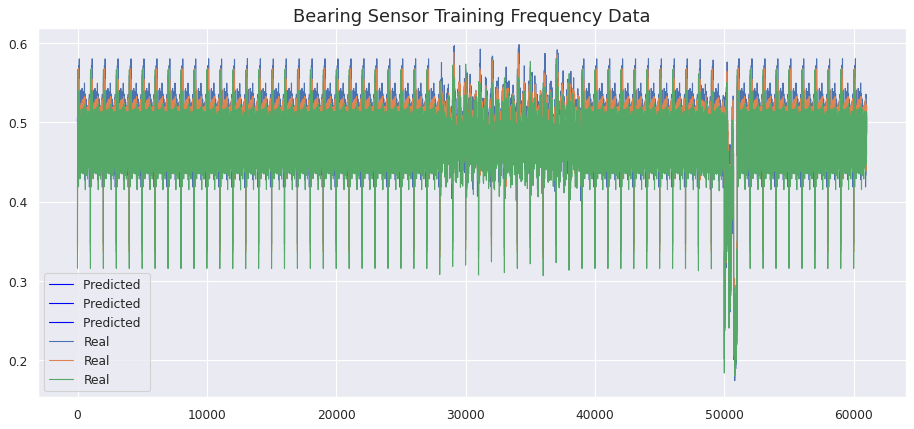

In [224]:
#pred=autoencoder_model.predict(np.array([X_train[25]]))
#real=autoencoder_model.predict(pred)
a=np.array(np.concatenate(np.array(X_train)))
print(a.shape)
pred=autoencoder_model.predict(np.array([a]))
real=autoencoder_model_conv.predict(np.array(X_train))
real=np.concatenate(real)
pred=np.concatenate(pred)

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)

ax.plot(X_train_reshaped[0], label='Predicted ', color='blue', animated = True, linewidth=1)
ax.plot(real, label='Real',  animated = True, linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

In [225]:
X_train[0]

array([[0.5038223 , 0.5023346 , 0.49993134],
       [0.5005951 , 0.50349426, 0.5068741 ],
       [0.4971695 , 0.50442505, 0.5034256 ],
       ...,
       [0.49905396, 0.49892426, 0.50019073],
       [0.496315  , 0.49892426, 0.49932098],
       [0.49939728, 0.5005646 , 0.500824  ]], dtype=float32)

In [219]:
pred*=1/pred.max()

In [217]:
pred=pred[50:]

In [227]:
real=autoencoder_model_conv.predict(np.array(X_train))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [262]:
real1,train=scale_minmax(real[0][50:], X_train[0])


In [253]:
real1.shape

(61, 1000, 3)

In [259]:
def scale_minmax(arr, arr2):
    minim=min(arr.min(),arr2.min())
    maxim=max(arr.max(),arr2.max())
    return (arr - minim) / (maxim - minim), (arr2 - minim) / (maxim - minim)

In [247]:
scale_minmax(X_train_reshaped[0])

array([[0.65623679, 0.57378436, 0.44059197],
       [0.47737844, 0.63805497, 0.82536998],
       [0.28752643, 0.68964059, 0.63424947],
       ...,
       [0.594926  , 0.12727273, 0.51966173],
       [0.45750529, 0.50782241, 0.49556025],
       [0.41945032, 0.61310782, 0.46004228]])

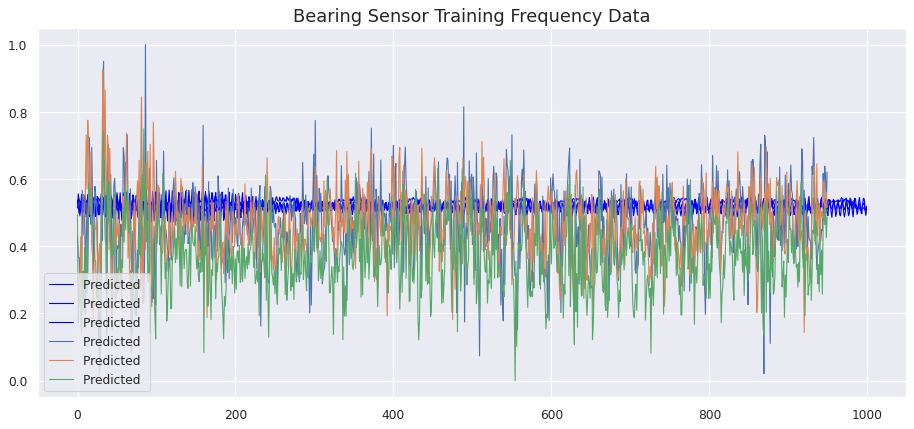

In [265]:
#pred=autoencoder_model.predict(np.array([X_train[25]]))
#real=autoencoder_model.predict(pred)

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)

ax.plot(train, label='Predicted ', color='blue', animated = True, linewidth=1)
ax.plot(real1, label='Predicted ',  animated = True, linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

In [229]:
preds=[]
for i in X_train_reshaped:
    preds.extend(autoencoder_squeeze.predict(np.array([i])))


KeyboardInterrupt



In [75]:
preds=best_model.predict(np.array([X_train_processed[0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [62]:
preds1=np.concatenate(preds)

In [72]:
np.array(X_train_processed).shape

(61, 1000, 3)

In [78]:
best_model.summary()

Model: "TimeSeries_Anomaly_Detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 1000, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_LSTM_0 (LSTM)           │ (None, 8)              │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bottleneck (Dense)              │ (None, 28)             │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Reshape (Reshape)       │ (None, 1, 28)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_LSTM_0 (LSTM)           │ (None, 1, 8)           │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_LSTM_1 (LSTM)           │ (None, 1, 8)           │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_LSTM_2 (LSTM)           │ (None, 1, 16)          │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (TimeDistributed)  │ (None, 1, 3)           │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,015 (15.68 KB)

 Trainable params: 4,015 (15.68 KB)

 Non-trainable params: 0 (0.00 B)

In [170]:
reals.shape

(66000, 3)

In [185]:
reals[20024]

array([0.48852901, 0.70209654, 0.56719469])

In [70]:
def autoencoder_merge(input_encoder, reference_encoder, X):
    """
    Builds a merged model using two pre-trained encoders, concatenates their outputs,
    and computes a similarity score.

    Parameters:
        input_encoder (Model): Pre-trained encoder for input sequence.
        reference_encoder (Model): Pre-trained encoder for reference sequence.
        X_seq (ndarray): Input data for the input encoder.
        X_ref (ndarray): Input data for the reference encoder.

    Returns:
        Model: A model that combines the encoders and computes a similarity score.
    """
    # Input for sequence 1
    inputs_seq = Input(shape=(X[0].shape[1], X[0].shape[2]), name='Input_Sequence')
    reshaped_seq = Reshape(target_shape=(-1, X[0].shape[1] * X[0].shape[2]))(inputs_seq)

    encoded_seq = input_encoder(inputs_seq)  # Pass through the first encoder

    # Input for reference sequence
    inputs_ref = Input(shape=(X[0].shape[1], X[1].shape[2]), name='Input_Reference')
    reshaped_ref = Reshape(target_shape=(-1, X[0].shape[1] * X[0].shape[2]))(inputs_ref)
    
    encoded_ref = reference_encoder(inputs_ref)  # Pass through the second encoder

    # Combine the encoded outputs
    combined = Concatenate(name="Concatenated_Encodings")([encoded_ref, encoded_seq])


    similarity_score = Dense(1, activation='sigmoid', name='Similarity_Score')(combined)

    model = Model(inputs=[inputs_seq, inputs_ref], outputs=similarity_score, name="Merged_Encoder_Model")

    
    return model



In [71]:
merged_model= autoencoder_merge(encoder, encoder, [X_train[0], X_train[0]])
merged_model.compile(optimizer='adam', loss='mse')
merged_model.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 4), (None, None, 4)]

In [69]:
seq, ref = np.array(X_train[0]), np.array(X_train[0])
# Prepare inputs
seq = np.expand_dims(np.array(X_train[0]), axis=0)  # Add batch dimension
ref = np.expand_dims(np.array(X_train[0]), axis=0)  # Add batch dimension

# Prepare target
y = np.array([1])  # Single output target

# Check shapes
print("Shape of seq:", seq.shape)  # (1, timesteps, features)
print("Shape of ref:", ref.shape)  # (1, timesteps, features)
print("Shape of target y:", y.shape)  # (1,)

# Fit the model
merged_model.fit([seq, ref], y, batch_size=1, epochs=1, verbose=1)

print(np.array([[seq], [ref]]).shape)
print(seq.shape)
inputA=np.array([seq,ref])
r=np.reshape(inputA, (1, *inputA.shape))
print(r.shape)
# Pass the inputs as a tuple of arrays
merged_model.fit(r, np.array([1]), batch_size=1, epochs=1, verbose=1)


Shape of seq: (1, 18189, 1, 3)
Shape of ref: (1, 18189, 1, 3)
Shape of target y: (1,)


ValueError: Input 0 of layer "Merged_Encoder_Model" is incompatible with the layer: expected shape=(None, 1, 3), found shape=(1, 18189, 1, 3)

In [33]:
X_train[0].shape

(18189, 1, 3)

In [80]:
input_seq = X_train[0]  # Shape: (1, 1, 3)
input_ref = X_train[0]  # Shape: (1, 1, 3)

# Labels need to match the batch size
labels = np.array([1])  # Same sample: label = 1
# Train the model
merged_model.fit(
    [input_seq, input_ref],  
    labels,                  # Corresponding label
    batch_size=1,
    epochs=1,
    verbose=1
)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 18189, 18189
'y' sizes: 1


In [210]:
merged_model.predict(
    [input_seq, input_ref],  # Two inputs with shape (1, 1, 3)
    ) 

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [26]:
train_pairwise_similarity(merged_model, X_train, X_train)

Epoch 1/1


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (36, 1) + inhomogeneous part.

In [208]:
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Lambda, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K

def unified_autoencoder_merge_model(features):
    """
    Builds a single model that computes a similarity score between two datasets
    with variable-length sequences.

    Parameters:
        features (int): Number of features per timestep.

    Returns:
        Model: A unified model for similarity score computation.
    """

    # Shared encoder with Masking for padded values
    def shared_encoder(input_layer, name_prefix):
        x = Masking(mask_value=0.0, name=f"{name_prefix}_Masking")(input_layer)  # Mask padded values
        x = LSTM(8, activation='relu', return_sequences=False, name=f"{name_prefix}_LSTM")(x)
        return x

    # Inputs
    input_seq = Input(shape=(None, features), name="Input_Sequence")  # Variable-length input
    input_ref = Input(shape=(None, features), name="Input_Reference")

    # Shared encoder
    encoded_seq = shared_encoder(input_seq, "Encoder_Seq")
    encoded_ref = shared_encoder(input_ref, "Encoder_Ref")

    # Combine encodings and compute similarity
    combined = Concatenate(name="Concatenated_Encodings")([encoded_seq, encoded_ref])
    similarity_score = Dense(1, activation='sigmoid', name="Similarity_Score")(combined)

    # Define the final model
    model = Model(inputs=[input_seq, input_ref], outputs=similarity_score, name="Variable_Length_Similarity_Model")

    return model

# ----------------------------
# Example Data and Training
# ----------------------------
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Simulate datasets with variable-length sequences
num_datasets = 6
features = 3

# Generate variable-length sequences (lists of sequences)
X_train = [
    np.random.random((5, features)),  # 5 timesteps
    np.random.random((7, features)),  # 7 timesteps
    np.random.random((6, features)),  # 6 timesteps
    np.random.random((8, features)),  # 8 timesteps
    np.random.random((4, features)),  # 4 timesteps
    np.random.random((3, features))   # 3 timesteps
]

# Pad the sequences to ensure uniform input shape
X_train_padded = [pad_sequences(X_train, padding='post', dtype='float32')]

# Prepare input pairs and labels
input_seq_list = []
input_ref_list = []
labels = []

for i, dataset_i in enumerate(X_train_padded):
    for j, dataset_j in enumerate(X_train_padded):
        input_seq_list.append(dataset_i)  # Dataset i
        input_ref_list.append(dataset_j)  # Dataset j
        labels.append(1 if i == j else 0)  # 1 for same dataset, 0 otherwise

# Convert to numpy arrays
input_seq_array = np.array(input_seq_list, dtype=object)
input_ref_array = np.array(input_ref_list, dtype=object)
labels_array = np.array(labels)

# Build and compile the model
model = unified_autoencoder_merge_model(features)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ----------------------------
# Train the Model
# ----------------------------
# Use a generator to handle variable-length sequences
def data_generator(input_seq_array, input_ref_array, labels_array, batch_size=2):
    while True:
        for i in range(0, len(labels_array), batch_size):
            X_seq_batch = pad_sequences(input_seq_array[i:i+batch_size], padding='post', dtype='float32')
            X_ref_batch = pad_sequences(input_ref_array[i:i+batch_size], padding='post', dtype='float32')
            y_batch = labels_array[i:i+batch_size]
            yield [X_seq_batch, X_ref_batch], y_batch

# Train using the generator
batch_size = 2
steps_per_epoch = len(labels_array) // batch_size

model.fit(
    data_generator(input_seq_array, input_ref_array, labels_array, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    verbose=1
)


Model: "Variable_Length_Similarity_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Sequence      │ (None, None, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Reference     │ (None, None, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None, 3)   │          0 │ Input_Sequence[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, None, 3)   │          0 │ Input_Reference[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Seq_Masking │ (None, None, 3)   │          0 │ Input_Sequence[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_4 (Any)         │ (None, None)      │          0 │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Ref_Masking │ (None, None, 3)   │          0 │ Input_Reference[… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_5 (Any)         │ (None, None)      │          0 │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Seq_LSTM    │ (None, 8)         │        384 │ Encoder_Seq_Mask… │
│ (LSTM)              │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Ref_LSTM    │ (None, 8)         │        384 │ Encoder_Ref_Mask… │
│ (LSTM)              │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenated_Encod… │ (None, 16)        │          0 │ Encoder_Seq_LSTM… │
│ (Concatenate)       │                   │            │ Encoder_Ref_LSTM… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Similarity_Score    │ (None, 1)         │         17 │ Concatenated_Enc… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 785 (3.07 KB)

 Trainable params: 785 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

In [209]:
merged_model.fit([X_train_padded, X_train_padded], [1]*6)

ValueError: Unrecognized data type: x=[[array([[[0.48665613, 0.7575461 , 0.22419193],
        [0.70977527, 0.19250089, 0.47933692],
        [0.1275385 , 0.28434345, 0.10319058],
        [0.32444346, 0.62952244, 0.616568  ],
        [0.23855427, 0.1292784 , 0.9159942 ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.49442244, 0.5507985 , 0.6474251 ],
        [0.8448279 , 0.9713487 , 0.11826349],
        [0.04485699, 0.15855114, 0.9514234 ],
        [0.42671958, 0.5068355 , 0.02535993],
        [0.01561448, 0.5521159 , 0.8069986 ],
        [0.9357415 , 0.10729955, 0.08131639],
        [0.08966619, 0.350091  , 0.53295946],
        [0.        , 0.        , 0.        ]],

       [[0.7308249 , 0.03820163, 0.61844814],
        [0.31595588, 0.41919622, 0.25784838],
        [0.13949774, 0.37026706, 0.87647605],
        [0.6776834 , 0.6933008 , 0.09490417],
        [0.40231648, 0.65045804, 0.18411894],
        [0.23532525, 0.125584  , 0.4057497 ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.9095843 , 0.0935088 , 0.3975831 ],
        [0.9882468 , 0.37867433, 0.44154182],
        [0.13615604, 0.887969  , 0.13196672],
        [0.9356676 , 0.38429478, 0.3446175 ],
        [0.49796277, 0.10103603, 0.3972039 ],
        [0.8320667 , 0.9811337 , 0.7086932 ],
        [0.6955417 , 0.4191459 , 0.49621764],
        [0.58550084, 0.8593584 , 0.6039253 ]],

       [[0.15462829, 0.39819458, 0.89101976],
        [0.7215934 , 0.7849272 , 0.8590376 ],
        [0.44141144, 0.8602335 , 0.2158588 ],
        [0.845622  , 0.9849817 , 0.02109464],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.91716546, 0.2172176 , 0.65840405],
        [0.00305501, 0.88442403, 0.9650001 ],
        [0.7471086 , 0.0443766 , 0.03142059],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]], dtype=float32)], [array([[[0.48665613, 0.7575461 , 0.22419193],
        [0.70977527, 0.19250089, 0.47933692],
        [0.1275385 , 0.28434345, 0.10319058],
        [0.32444346, 0.62952244, 0.616568  ],
        [0.23855427, 0.1292784 , 0.9159942 ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.49442244, 0.5507985 , 0.6474251 ],
        [0.8448279 , 0.9713487 , 0.11826349],
        [0.04485699, 0.15855114, 0.9514234 ],
        [0.42671958, 0.5068355 , 0.02535993],
        [0.01561448, 0.5521159 , 0.8069986 ],
        [0.9357415 , 0.10729955, 0.08131639],
        [0.08966619, 0.350091  , 0.53295946],
        [0.        , 0.        , 0.        ]],

       [[0.7308249 , 0.03820163, 0.61844814],
        [0.31595588, 0.41919622, 0.25784838],
        [0.13949774, 0.37026706, 0.87647605],
        [0.6776834 , 0.6933008 , 0.09490417],
        [0.40231648, 0.65045804, 0.18411894],
        [0.23532525, 0.125584  , 0.4057497 ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.9095843 , 0.0935088 , 0.3975831 ],
        [0.9882468 , 0.37867433, 0.44154182],
        [0.13615604, 0.887969  , 0.13196672],
        [0.9356676 , 0.38429478, 0.3446175 ],
        [0.49796277, 0.10103603, 0.3972039 ],
        [0.8320667 , 0.9811337 , 0.7086932 ],
        [0.6955417 , 0.4191459 , 0.49621764],
        [0.58550084, 0.8593584 , 0.6039253 ]],

       [[0.15462829, 0.39819458, 0.89101976],
        [0.7215934 , 0.7849272 , 0.8590376 ],
        [0.44141144, 0.8602335 , 0.2158588 ],
        [0.845622  , 0.9849817 , 0.02109464],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.91716546, 0.2172176 , 0.65840405],
        [0.00305501, 0.88442403, 0.9650001 ],
        [0.7471086 , 0.0443766 , 0.03142059],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]], dtype=float32)]] (of type <class 'list'>)

In [206]:
for X in [[1,2,3],[1,2]]:
    print(X)

[1, 2, 3]
[1, 2]


In [9]:
# fit the model to the data
nb_epochs = 1
batch_size = 10
input_data=[]
output_data=[]
for train_j in range(len(X_train)):
    for train_i in range(len(X_train)):
        if len(X_train[train_i])<=len(X_train[train_j]):
            if train_j != train_i:
                # Create a pair of training data and the corresponding output
                x_input = (X_train[train_i],X_train[train_j][1:len(X_train[train_i])])
                y_output = X_train[train_i] * 10  # Adjust this according to your target needs
                input_data.append(x_input)
                output_data.append(y_output)
                # Train the model on this data pair
                history = model.fit(x_input, y_output, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history
            else:
                # This block might need adjustment, as it uses the same data point
                x_input = (X_train[train_i], X_train[train_i])
                y_output = X_train[train_i],0  # Ensure this is the desired target
                input_data.append(x_input)
                output_data.append(y_output)
                # Train the model on this data pair
                history = model.fit(x_input, y_output, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history
#history = model.fit(x_input, y_output, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history


ValueError: Argument `validation_split` is only supported for tensors or NumPy arrays.Found incompatible type in the input: [<class 'int'>]

In [36]:
X_train[0][0:10].shape


(10, 1, 3)

In [31]:
def test_model(model, X_test, nb_samples=10):
    results = []  # To store inputs and outputs
    sample_count = 0  # To track how many samples we've processed

    for test_i in range(len(X_test)):
        for test_j in range(len(X_test)):
            if len(X_test[test_i]) <= len(X_test[test_j]):
                if test_j != test_i:
                    # Create a pair of test data
                    x_input = (X_test[test_i], X_test[test_j][1:len(X_test[test_i])])
                else:
                    # Use the same data point as input
                    x_input = (X_test[test_i], X_test[test_i])

                # Predict the output using the trained model
                y_pred = model.predict([x_input[0], x_input[1]])

                # Store the input and output in the results list
                results.append({
                    'input_1': x_input[0],
                    'input_2': x_input[1],
                    'output': y_pred,
                    'info':{
                        'source': str(test_i),
                        'reference':str(test_j)
                    }
                })

                # Increment the sample count and check if we reached the limit
                sample_count += 1
                if sample_count >= nb_samples:
                    return results

    return results


In [32]:
result=test_model(model, X_train)


569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 10458, 10457


In [133]:
result[1]["info"]

{'source': '1', 'reference': '0'}

In [1]:
input_1 = result[1]["input_1"].squeeze()  # Flatten and get the last dimension (ignoring the 1)
print(input_1.shape)
# Create x-axis for plotting
x = np.arange(len(input_1))

plt.figure(figsize=(10, 5))
plt.plot(x, input_1[:, 0], label='Feature 1')
plt.plot(x, input_1[:, 1], label='Feature 2')
plt.plot(x, input_1[:, 2], label='Feature 3')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Features 1, 2, and 3 vs Index')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'result' is not defined

In [12]:
anomalies = {}
for res in result:
    input_1=res["input_1"].squeeze()
    input_2=res["input_2"].squeeze() 
    output=res["output"].squeeze() 
    info=res["info"]
    print(info)
    for i in range(len(input_1)):
        if abs(input_1[i][0]- output[i][0])>0.1:
            anomalies[str(info)]=anomalies.get(str(info), 0)+1
print(anomalies)

{'source': '0', 'reference': '0'}
{'source': '1', 'reference': '0'}
{'source': '1', 'reference': '1'}
{'source': '1', 'reference': '2'}
{'source': '2', 'reference': '0'}
{'source': '2', 'reference': '2'}
{'source': '3', 'reference': '0'}
{'source': '3', 'reference': '1'}
{'source': '3', 'reference': '2'}
{'source': '3', 'reference': '3'}
{"{'source': '1', 'reference': '0'}": 3941, "{'source': '1', 'reference': '2'}": 3821, "{'source': '2', 'reference': '0'}": 4291, "{'source': '3', 'reference': '0'}": 3185, "{'source': '3', 'reference': '1'}": 3221, "{'source': '3', 'reference': '2'}": 3142}


In [176]:
print(len(result))

10


In [19]:
def representative_data_gen():
    for i in range(100):  # Adjust the range as needed
        input_data = X_train[i:i+1]  # Ensure this slices correctly
        #print(f"Yielding data shape: {input_data.shape}, dtype: {input_data.dtype}")
        yield [input_data.astype(np.float32)]


In [68]:
X_train[0]+10

array([[[10.80276134, 10.51677852, 10.4518647 ]],

       [[10.52465483, 10.58964525, 10.84648742]],

       [[10.22945431, 10.64813039, 10.65047702]],

       ...,

       [[10.70742932, 10.0105465 , 10.5329575 ]],

       [[10.49375411, 10.44199425, 10.50823938]],

       [[10.43458251, 10.56136146, 10.47181266]]])

In [25]:
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda
# create the autoencoder model
#model = autoencoder_model2(X_train)
#model.compile(optimizer='adam', loss='mae')
#model.summary()
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.allow_custom_ops = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # Set input type to int8
converter.inference_output_type = tf.int8  #
converter.experimental_new_converter = True
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # TensorFlow Lite built-in operations
    tf.lite.OpsSet.SELECT_TF_OPS     # TensorFlow operations that are not natively supported
]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()
with open('./autoencoder_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpd8zs8ue1/assets


INFO:tensorflow:Assets written to: /tmp/tmpd8zs8ue1/assets


Saved artifact at '/tmp/tmpd8zs8ue1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 4), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 1, 4), dtype=tf.float32, name=None)
Captures:
  140003623771152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623771536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623770576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623773264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623773456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623772112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623773648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623776336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623775568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623776912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623778448:

/home/pietro/.local/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1733234076.027220  235600 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733234076.027239  235600 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-03 14:54:36.027541: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpd8zs8ue1
2024-12-03 14:54:36.031194: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-03 14:54:36.031245: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpd8zs8ue1
2024-12-03 14:54:36.063010: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-03 14:54:36.173925: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpd8zs

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test2)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test2.reshape(X_test2.shape[0], X_test2.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored=pd.concat([scored_train, scored])

In [ ]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

In [ ]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [ ]:
# save all model information, including weights, in h5 format
model.save("bearing-sensor-anomaly-detection.h5")
print("Model saved")